## Imports/Setup

In [1]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Salinity (SSS)

#### Met Office Hadley

In [ ]:
#SST requires downloading yearly zip files and extracting each month from each  (1900-01 to present only)
#More info found on https://www.metoffice.gov.uk/hadobs/en4/download-en4-2-2.html
#Note: because the file names in the zip are not known until extracting, this cell will execute even if the data already has been downloaded

sss_direct_url_base = 'https://www.metoffice.gov.uk/hadobs/en4/data/en4-2-1/EN.4.2.2/'
sss_destination_filename_base = 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_' #_197901+
sss_destination_folder = global_vars['download_folder']+r'SSS/originals/'
for year in range(acquisition_start_year, acquisition_end_year+1, 1):
    if year >= 2021: sss_direct_url_base = 'https://www.metoffice.gov.uk/hadobs/en4/data/en4-2-1/' #2021 and onward the URL changes, though both URL zips exists. Not clear why.
    url_file = 'EN.4.2.2.analyses.g10.'+str(year)+'.zip'
    sss_direct_url = sss_direct_url_base + url_file
    sss_destination_filename = sss_destination_filename_base+str(year)+'.zip'
    
    #download to tmp, extract a year, then transfer all to destination
    tmp_folder = '../../tmp/'
    download_to_folder(sss_direct_url, tmp_folder, sss_destination_filename,overwrite=False, create_dest=True)
    ZipFile(tmp_folder+sss_destination_filename).extractall(tmp_folder)
    files = glob.glob(tmp_folder+'EN.4.2.2.f.analysis.g10.*.nc')
    for f in files:  #for each file extracted
        basename = os.path.basename(f)
        tmp_xr = xr.open_dataset(tmp_folder + basename)
        output_xarray_with_date(tmp_xr, sss_destination_folder, basename, filetype=output_file_type, with_date=False) 
            #Note the filename is kept as the original from the .zip here to be compatible with other work. To output the file with a different name, edit the dest_file string parameter.
        os.remove(os.path.join(tmp_folder,f)) #remove tmp file
    
    #remove zip file too
    os.remove(os.path.join(tmp_folder,sss_destination_filename)) #remove tmp file
print("SSS Complete")

## Processing: Salinity (SSS)

#### Met Office Hadley

In [46]:
sss = xr_open_mfdataset_custom(global_vars['download_folder']+'SSS/originals/EN.4.2.2.f.analysis.g10.*.nc') 
#sss

Encountered an error - trying with gs://leap-persistent/ds4114/online_data/SSS/originals/EN.4.2.2.f.analysis.g10.*.zarr
Success.


In [48]:
%%time
#effectively ignore the depth dimension because we dont need it
sss_nodepth = xr.Dataset({'sss':(['time','lat','lon'],sss.salinity[:,0,:,:].values),'time':(['time'],sss.time.data),'lat':(['lat'],sss.lat.data),'lon':(['lon'],sss.lon.data)})
#Note this removes attributes from SSS raw data so we lose some metadata but this is OK for this analysis
sss_filtered = sss_nodepth.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter years

#Regrid lat/lon
sss_regridder = xesmf.Regridder(sss_filtered, ideal_grid, 'bilinear', periodic=True)  #data is already 1x1 but we want to shift coordinates
sss_out = sss_regridder(sss_filtered.chunk(-1), keep_attrs=True)
#sss_out

CPU times: user 14.7 s, sys: 1.02 s, total: 15.7 s
Wall time: 1min 25s


In [49]:
sss_out = sss_out.rename({'latitude': 'ylat','longitude': 'xlon'}) #rename to be consistent with prior work
sss_out = sss_out.assign_coords(time=ttime) #overwrite time dimension to be midmonth
#sss_out = sss_out.assign_coords(time=ttime[:-1]) #you can use this line if SSS hasnt updated and we are missing the last month.

In [51]:
output_xarray_with_date(sss_out, global_vars['download_folder']+'SSS/processed/', 'SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses', output_file_type)

Cancelling output - SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_198201-202304.zarr already exists in gs://leap-persistent/ds4114/online_data/SSS/processed/


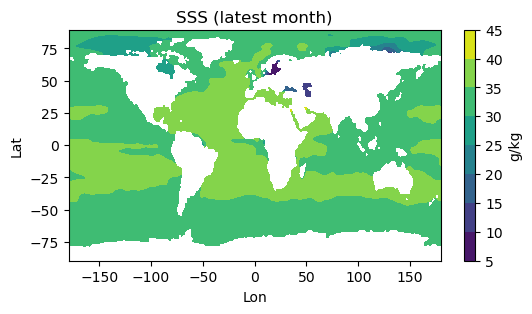

In [50]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.contourf(ideal_grid.longitude,ideal_grid.latitude,sss_out.sss[-1,:,:]) #just choosing latest time slice
plt.title('SSS (latest month)'); plt.xlabel('Lon'); plt.ylabel('Lat')
plt.colorbar().set_label('g/kg');